[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
4/4 [==============================] - 5s 369ms/step - loss: 0.0397 - val_loss: 0.0215
Epoch 2/50
4/4 [==============================] - 0s 81ms/step - loss: 0.0174 - val_loss: 0.0526
Epoch 3/50
4/4 [==============================] - 0s 84ms/step - loss: 0.0086 - val_loss: 0.1013
Epoch 4/50
4/4 [==============================] - 0s 82ms/step - loss: 0.0086 - val_loss: 0.0377
Epoch 5/50
4/4 [==============================] - 0s 95ms/step - loss: 0.0040 - val_loss: 0.0092
Epoch 6/50
4/4 [==============================] - 0s 94ms/step - loss: 0.0052 - val_loss: 0.0093
Epoch 7/50
4/4 [==============================] - 0s 79ms/step - loss: 0.0028 - val_loss: 0.0243
Epoch 8/50
4/4 [==============================] - 0s 85ms/step - loss: 0.0037 - val_loss: 0.0228
Epoch 9/50
4/4 [==============================] - 0s 83ms/step - loss: 0.0032 - val_loss: 0.0056
Epoch 10/50
4/4 [==============================] - 0s 112ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 11/50
4/4 [==========

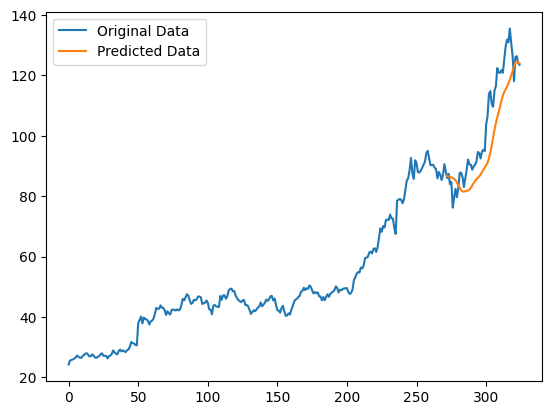

1/1 [==============================] - 0s 24ms/step


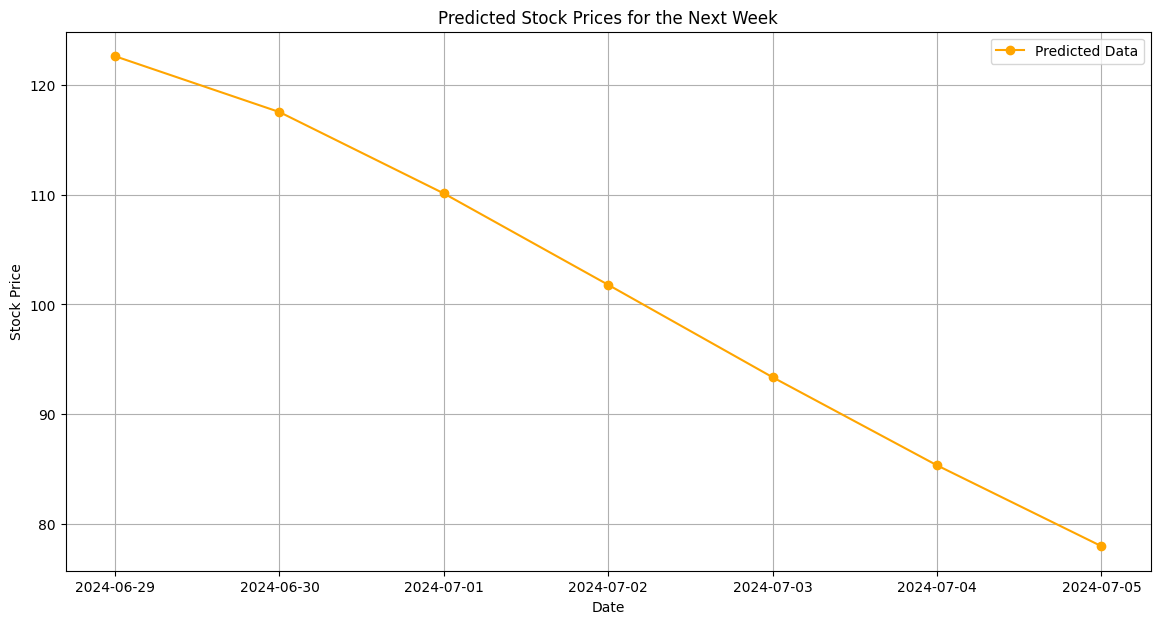

Predicted Opening and Closing Prices for the Next Week:
2024-06-29: Open: 122.63, Close: 122.63
2024-06-30: Open: 117.54, Close: 117.54
2024-07-01: Open: 110.12, Close: 110.12
2024-07-02: Open: 101.79, Close: 101.79
2024-07-03: Open: 93.36, Close: 93.36
2024-07-04: Open: 85.33, Close: 85.33
2024-07-05: Open: 77.96, Close: 77.96


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
import pandas as pd

# Download stock data
stock_data = yf.download('NVDA', start='2023-01-01', end='2024-07-01')

# Function to compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to compute MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd - signal

# Create additional features
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()  # 20-day moving average
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()  # 50-day moving average
stock_data['RSI'] = compute_rsi(stock_data['Close'])  # Relative Strength Index
stock_data['MACD'] = compute_macd(stock_data['Close'])  # MACD

# Drop NaN values created by moving averages and indicators
stock_data.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close', 'Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50', 'RSI', 'MACD']].values)

# Create dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 0])  # Predicting 'Close' price
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Check if the dataset is empty
if X.size == 0 or y.size == 0:
    raise ValueError("Not enough data to create the dataset with the given time_step. Please use a smaller time_step.")

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(units=64))
model.add(Dense(units=1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Predict the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], X.shape[2]-1))), axis=1))[:, 0]

# Plot the original and predicted data
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions

plt.plot(original_data, label='Original Data')
plt.plot(predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Predict the next week's stock prices
X_input = scaled_data[-time_step:].reshape(1, time_step, X.shape[2])
predictions = []

for _ in range(7):
    next_prediction = model.predict(X_input)
    predictions.append(next_prediction[0, 0])
    next_input = np.concatenate((next_prediction, np.zeros((1, X.shape[2]-1))), axis=1)
    X_input = np.append(X_input[:, 1:, :], next_input.reshape(1, 1, X.shape[2]), axis=1)

predicted_prices = scaler.inverse_transform(np.concatenate((np.array(predictions).reshape(-1, 1), np.zeros((len(predictions), X.shape[2]-1))), axis=1))[:, 0]

# Generate dates for the next week
last_date = stock_data.index[-1]
dates = [last_date + timedelta(days=i) for i in range(1, 8)]

# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.plot(dates, predicted_prices, marker='o', linestyle='-', color='orange', label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted Stock Prices for the Next Week')
plt.legend()
plt.grid(True)
plt.show()

# Print the predicted opening and closing prices for each day
print("Predicted Opening and Closing Prices for the Next Week:")
for i, date in enumerate(dates):
    print(f"{date.date()}: Open: {predicted_prices[i]:.2f}, Close: {predicted_prices[i]:.2f}")
